<a href="https://colab.research.google.com/github/Meta-Sean/Practical-Deep-Learning/blob/main/spaceship_titanic_linear_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Space Titanic
- Predict which passengers are transported to an alternate dimension

# File and Data Field Descriptions
- train.csv - Personal records for about two-thirds (~8700) of the    passengers, to be used as training data.
  - PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
  - HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
  - CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
  - Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
  - Destination - The planet the passenger will be debarking to.
  - Age - The age of the passenger.
  - VIP - Whether the passenger has paid for special VIP service during the voyage.
  - RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
  - Name - The first and last names of the passenger.
  - Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
- test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.
sample_submission.csv - A submission file in the correct format.
  - PassengerId - Id for each passenger in the test set.
  - Transported - The target. For each passenger, predict either True or False.

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
! mkdir ~/.kaggle #creating folder
! cp kaggle.json ~/.kaggle/ #copying kaggle.json
! chmod 600 ~/.kaggle/kaggle.json #reading the file with full access

In [5]:
from pathlib import Path
import os

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    path = Path('../input/spaceship-titanic')
    !pip install -Uqq fastai
else:
    import zipfile,kaggle
    path = Path('spaceship-titanic')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 299k/299k [00:00<00:00, 51.4MB/s]

# Lets start by building a simple linear model to predict if our passenger was transported or not

In [118]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

In [119]:
df = pd.read_csv('spaceship-titanic/train.csv')
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [120]:
df.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [121]:
modes = df.mode().iloc[0]
modes

PassengerId                0001_01
HomePlanet                   Earth
CryoSleep                    False
Cabin                      G/734/S
Destination            TRAPPIST-1e
Age                           24.0
VIP                          False
RoomService                    0.0
FoodCourt                      0.0
ShoppingMall                   0.0
Spa                            0.0
VRDeck                         0.0
Name            Alraium Disivering
Transported                   True
Name: 0, dtype: object

In [122]:
df.fillna(modes, inplace=True)

In [123]:
import numpy as np
df.describe(include=(np.number))

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,28.728517,220.009318,448.434027,169.572300,304.588865,298.261820
std,14.355438,660.519050,1595.790627,598.007164,1125.562559,1134.126417
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,41.000000,61.000000,22.000000,53.000000,40.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


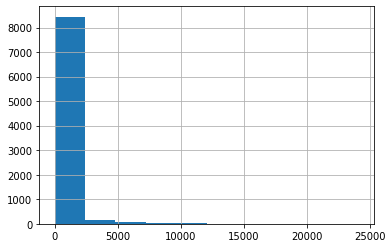

In [124]:
df['VRDeck'].hist()

All of these luxury amenities have some big outlier, crazy rich aliens!, lets take the log of all these columns so our models handles these data points well

In [125]:
df['LogRoomService'] = np.log(df['RoomService']+1)
df['LogFoodCourt'] = np.log(df['FoodCourt']+1)
df['LogShoppingMall'] = np.log(df['ShoppingMall']+1)
df['LogSpa'] = np.log(df['Spa']+1)
df['LogVRDeck'] = np.log(df['VRDeck']+1)

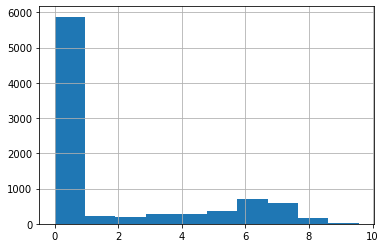

In [126]:
df['LogRoomService'].hist()

nice much cleaner to work with!

## Now lets take a look at our non-numeric columns in the data-set

In [127]:
df.describe(include=[object])

,PassengerId,HomePlanet,Cabin,Destination,Name
count,8693,8693,8693,8693,8693
unique,8693,3,6560,3,8473
top,0001_01,Earth,G/734/S,TRAPPIST-1e,Alraium Disivering
freq,1,4803,207,6097,202


It looks like there are only 3 home planets (Earth, Europa, and Mars) and only 3 destinations, the rest of the data is pretty intuitive.

Going to create some dummy variables for HomePlanet, CryoSleep, Destination, and VIP

In [128]:
df = pd.get_dummies(df, columns=['HomePlanet', 'CryoSleep', 'Destination', 'VIP'])
df.columns

Index(['PassengerId', 'Cabin', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported', 'LogRoomService',
       'LogFoodCourt', 'LogShoppingMall', 'LogSpa', 'LogVRDeck', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'CryoSleep_False', 'CryoSleep_True', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'VIP_False',
       'VIP_True'],
      dtype='object')

In [129]:
added_cols = ['HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'CryoSleep_False', 'CryoSleep_True', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'VIP_False',
       'VIP_True']
df[added_cols].head()

,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True
0,0,1,0,1,0,0,0,1,1,0
1,1,0,0,1,0,0,0,1,1,0
2,0,1,0,1,0,0,0,1,0,1
3,0,1,0,1,0,0,0,1,1,0
4,1,0,0,1,0,0,0,1,1,0


In [143]:
from torch import tensor

t_dep = tensor(df.Transported)

t_dep = torch.where(t_dep==False, torch.tensor(0), t_dep)
t_dep

tensor([0, 1, 0, 0, 1, 1, 1,  ..., 0, 1, 0, 0, 1, 0, 1])

Important to note here will are missing potentially important information from the Cabin and Name columns, which we will implement in our random forest model, but the cabin might be an important feature, but this model ignores that category right now.

In [144]:
indep_cols = ['Age', 'LogRoomService', 'LogFoodCourt', 'LogShoppingMall', 'LogSpa', 'LogVRDeck'] + added_cols

t_indep = tensor(df[indep_cols].values, dtype=torch.float)
t_indep

tensor([[39.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  ...,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,
          0.0000],
        [24.0000,  4.7005,  2.3026,  3.2581,  6.3099,  3.8067,  1.0000,  ...,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,
          0.0000],
        [58.0000,  3.7842,  8.1823,  0.0000,  8.8122,  3.9120,  0.0000,  ...,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,
          1.0000],
        [33.0000,  0.0000,  7.1577,  5.9189,  8.1107,  5.2679,  0.0000,  ...,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,
          0.0000],
        [16.0000,  5.7170,  4.2627,  5.0239,  6.3386,  1.0986,  1.0000,  ...,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,
          0.0000],
        [44.0000,  0.0000,  6.1821,  0.0000,  5.6768,  0.0000,  1.0000,  ...,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,
          0.0000],
        [26.0000,  3.7612,  7.3395,  1.3863,  0.0000,  0.0000,  1.0000,  ...,  1.0000,  0.0000

In [145]:
t_indep

tensor([[39.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  ...,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,
          0.0000],
        [24.0000,  4.7005,  2.3026,  3.2581,  6.3099,  3.8067,  1.0000,  ...,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,
          0.0000],
        [58.0000,  3.7842,  8.1823,  0.0000,  8.8122,  3.9120,  0.0000,  ...,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,
          1.0000],
        [33.0000,  0.0000,  7.1577,  5.9189,  8.1107,  5.2679,  0.0000,  ...,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,
          0.0000],
        [16.0000,  5.7170,  4.2627,  5.0239,  6.3386,  1.0986,  1.0000,  ...,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,
          0.0000],
        [44.0000,  0.0000,  6.1821,  0.0000,  5.6768,  0.0000,  1.0000,  ...,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,
          0.0000],
        [26.0000,  3.7612,  7.3395,  1.3863,  0.0000,  0.0000,  1.0000,  ...,  1.0000,  0.0000

In [146]:
torch.manual_seed(442)

n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff)-0.5
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625,  0.1722,  0.2324,
        -0.3575, -0.0010])

In [147]:
t_indep*coeffs

tensor([[   -18.0531,      0.0000,      0.0000,     -0.0000,     -0.0000,     -0.0000,      0.0000,  ...,     -0.4392,      0.0000,
              0.0000,      0.0000,      0.2324,     -0.3575,     -0.0000],
        [   -11.1096,      0.6514,      0.5547,     -0.7368,     -1.6611,     -1.1980,      0.4876,  ...,     -0.4392,      0.0000,
              0.0000,      0.0000,      0.2324,     -0.3575,     -0.0000],
        [   -26.8482,      0.5244,      1.9711,     -0.0000,     -2.3198,     -1.2312,      0.0000,  ...,     -0.4392,      0.0000,
              0.0000,      0.0000,      0.2324,     -0.0000,     -0.0010],
        [   -15.2757,      0.0000,      1.7243,     -1.3386,     -2.1351,     -1.6579,      0.0000,  ...,     -0.4392,      0.0000,
              0.0000,      0.0000,      0.2324,     -0.3575,     -0.0000],
        [    -7.4064,      0.7923,      1.0269,     -1.1362,     -1.6686,     -0.3458,      0.4876,  ...,     -0.4392,      0.0000,
              0.0000,      0.0000,      

In [148]:
vals, indicies = t_indep.max(dim=0)
t_indep = t_indep / vals

In [149]:
t_indep*coeffs

tensor([[-0.2285,  0.0000,  0.0000, -0.0000, -0.0000, -0.0000,  0.0000,  ..., -0.4392,  0.0000,  0.0000,  0.0000,  0.2324, -0.3575,
         -0.0000],
        [-0.1406,  0.0681,  0.0538, -0.0732, -0.1658, -0.1187,  0.4876,  ..., -0.4392,  0.0000,  0.0000,  0.0000,  0.2324, -0.3575,
         -0.0000],
        [-0.3399,  0.0548,  0.1913, -0.0000, -0.2316, -0.1220,  0.0000,  ..., -0.4392,  0.0000,  0.0000,  0.0000,  0.2324, -0.0000,
         -0.0010],
        [-0.1934,  0.0000,  0.1674, -0.1330, -0.2131, -0.1643,  0.0000,  ..., -0.4392,  0.0000,  0.0000,  0.0000,  0.2324, -0.3575,
         -0.0000],
        [-0.0938,  0.0828,  0.0997, -0.1129, -0.1666, -0.0343,  0.4876,  ..., -0.4392,  0.0000,  0.0000,  0.0000,  0.2324, -0.3575,
         -0.0000],
        [-0.2578,  0.0000,  0.1446, -0.0000, -0.1492, -0.0000,  0.4876,  ..., -0.4392,  0.0000,  0.0000,  0.1722,  0.0000, -0.3575,
         -0.0000],
        [-0.1523,  0.0545,  0.1716, -0.0312, -0.0000, -0.0000,  0.4876,  ..., -0.4392,  0.0000

In [150]:
t_indep = t_indep / vals

In [151]:
preds = (t_indep*coeffs).sum(axis=1)

In [152]:
preds[:10]

tensor([-0.2536, -0.1017,  0.0907, -0.2876, -0.0907, -0.1410, -0.0593,  0.5707, -0.0847,  0.5278])

In [153]:
t_dep

tensor([0, 1, 0, 0, 1, 1, 1,  ..., 0, 1, 0, 0, 1, 0, 1])

In [154]:
loss = torch.abs(preds-t_dep).mean()
loss

tensor(0.4931)

In [155]:
def calc_preds(coeffs, indeps): return (indeps*coeffs).sum(axis=1)
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

In [156]:
from fastai.data.transforms import RandomSplitter
trn_split,val_split=RandomSplitter(seed=42)(df)

In [170]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]
len(trn_indep),len(val_indep)

(6955, 1738)

In [158]:
def update_coeffs(coeffs, lr):
  coeffs.sub_(coeffs.grad *lr)
  coeffs.grad.zero_()

In [159]:
def one_epoch(coeffs, lr):
  loss = calc_loss(coeffs, trn_indep, trn_dep)
  loss.backward()
  with torch.no_grad(): update_coeffs(coeffs, lr)
  print(f"{loss:.3f}", end="; ")  

In [160]:
def init_coeffs(): return (torch.rand(n_coeff)-0.5).requires_grad_()

In [161]:
def train_model(epochs=30, lr=0.01):
  torch.manual_seed(442)
  coeffs = init_coeffs()
  for i in range(epochs): one_epoch(coeffs, lr=lr)
  return coeffs

In [162]:
coeffs = train_model(18, 0.2)

0.492; 0.383; 0.363; 0.343; 0.326; 0.323; 0.321; 0.382; 0.315; 0.321; 0.389; 0.408; 0.324; 0.307; 0.303; 0.356; 0.358; 0.425; 

In [188]:
def show_coeffs(): return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(-0.4708),
 'LogRoomService': tensor(-0.1844),
 'LogFoodCourt': tensor(0.1002),
 'LogShoppingMall': tensor(-0.3527),
 'LogSpa': tensor(-0.6181),
 'LogVRDeck': tensor(-0.6375),
 'HomePlanet_Earth': tensor(-0.7626),
 'HomePlanet_Europa': tensor(1.4229),
 'HomePlanet_Mars': tensor(0.4611),
 'CryoSleep_False': tensor(-7.0716),
 'CryoSleep_True': tensor(6.8831),
 'Destination_55 Cancri e': tensor(0.6886),
 'Destination_PSO J318.5-22': tensor(0.3107),
 'Destination_TRAPPIST-1e': tensor(-0.1918),
 'VIP_False': tensor(-0.0699),
 'VIP_True': tensor(-0.2482)}

Looks like you want to be in cryosleep and from Europa for your best chance of transportation. 

Lets measure our models accuracy - correct predicitons of survival

In [171]:
preds = calc_preds(coeffs, val_indep)

In [172]:
results = val_dep.bool()==(preds>0.5)
results[:16]

tensor([ True,  True, False,  True, False,  True, False, False,  True,  True,  True,  True,  True, False,  True, False])

In [173]:
results.float().mean()

tensor(0.7106)

In [174]:
def acc(coeffs): return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()
acc(coeffs)

tensor(0.7106)

In [184]:
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1))

In [185]:
coeffs = train_model(lr=100)

0.466; 0.283; 0.282; 0.282; 0.281; 0.281; 0.281; 0.281; 0.281; 0.281; 0.281; 0.281; 0.281; 0.281; 0.280; 0.280; 0.280; 0.280; 0.280; 0.280; 0.280; 0.280; 0.280; 0.280; 0.280; 0.280; 0.280; 0.280; 0.280; 0.280; 

In [186]:
acc(coeffs)

tensor(0.7106)

In [189]:
show_coeffs()

{'Age': tensor(-0.4708),
 'LogRoomService': tensor(-0.1844),
 'LogFoodCourt': tensor(0.1002),
 'LogShoppingMall': tensor(-0.3527),
 'LogSpa': tensor(-0.6181),
 'LogVRDeck': tensor(-0.6375),
 'HomePlanet_Earth': tensor(-0.7626),
 'HomePlanet_Europa': tensor(1.4229),
 'HomePlanet_Mars': tensor(0.4611),
 'CryoSleep_False': tensor(-7.0716),
 'CryoSleep_True': tensor(6.8831),
 'Destination_55 Cancri e': tensor(0.6886),
 'Destination_PSO J318.5-22': tensor(0.3107),
 'Destination_TRAPPIST-1e': tensor(-0.1918),
 'VIP_False': tensor(-0.0699),
 'VIP_True': tensor(-0.2482)}

In [194]:
tst_df = pd.read_csv('spaceship-titanic/test.csv')


In [195]:
tst_df.fillna(modes, inplace=True)
tst_df['LogRoomService'] = np.log(tst_df['RoomService']+1)
tst_df['LogFoodCourt'] = np.log(tst_df['FoodCourt']+1)
tst_df['LogShoppingMall'] = np.log(tst_df['ShoppingMall']+1)
tst_df['LogSpa'] = np.log(tst_df['Spa']+1)
tst_df['LogVRDeck'] = np.log(tst_df['VRDeck']+1)
tst_df = pd.get_dummies(tst_df, columns=['HomePlanet', 'CryoSleep', 'Destination', 'VIP'])
tst_indep = tensor(tst_df[indep_cols].values, dtype=torch.float)
tst_indep = tst_indep / vals

In [199]:
tst_df['Transported'] = (calc_preds(tst_indep, coeffs)>0.5).int()

In [212]:
sub_df = tst_df[['PassengerId', 'Transported']]
sub_df['Transported'] = sub_df['Transported'].apply(bool)
sub_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,False
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,False


In [213]:
sub_df.to_csv('sub.csv', index=False)

In [214]:
!head sub.csv

PassengerId,Transported
0013_01,True
0018_01,False
0019_01,True
0021_01,False
0023_01,False
0027_01,False
0029_01,True
0032_01,True
0032_02,True


In [215]:
! kaggle competitions submit -c spaceship-titanic -f sub.csv -m 'Simple linear model'

100% 57.0k/57.0k [00:00<00:00, 154kB/s]
Successfully submitted to Spaceship Titanic

In [236]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

In [237]:
df = pd.read_csv(path/'train.csv')

In [238]:
df.Name

0         Maham Ofracculy
1            Juanna Vines
2           Altark Susent
3            Solam Susent
4       Willy Santantines
              ...        
8688    Gravior Noxnuther
8689      Kurta Mondalley
8690         Fayey Connon
8691     Celeon Hontichre
8692     Propsh Hontichre
Name: Name, Length: 8693, dtype: object

In [239]:
def add_features(df):
  df['LogRoomService'] = np.log(df['RoomService']+1)
  df['LogFoodCourt'] = np.log(df['FoodCourt']+1)
  df['LogShoppingMall'] = np.log(df['ShoppingMall']+1)
  df['LogSpa'] = np.log(df['Spa']+1)
  df['LogVRDeck'] = np.log(df['VRDeck']+1)
  df[['Deck','CabinNumber','Side']] = df.Cabin.str.split('/', expand=True)
  df[['Group', 'PassengerNumber']] = df.PassengerId.str.split('_', expand=True)

add_features(df)

In [240]:
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,LogRoomService,LogFoodCourt,LogShoppingMall,LogSpa,LogVRDeck,Deck,CabinNumber,Side,Group,PassengerNumber
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,B,0,P,0001,01
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,...,4.70,2.30,3.26,6.31,3.81,F,0,S,0002,01
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.00,True,43.00,3576.00,0.00,...,3.78,8.18,0.00,8.81,3.91,A,0,S,0003,01
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.00,False,0.00,1283.00,371.00,...,0.00,7.16,5.92,8.11,5.27,A,0,S,0003,02
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.00,False,303.00,70.00,151.00,...,5.72,4.26,5.02,6.34,1.10,F,1,S,0004,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.00,True,0.00,6819.00,0.00,...,0.00,8.83,0.00,7.40,4.32,A,98,P,9276,01
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.00,False,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,G,1499,S,9278,01
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.00,False,0.00,0.00,1872.00,...,0.00,0.00,7.54,0.69,0.00,G,1500,S,9279,01
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.00,False,0.00,1049.00,0.00,...,0.00,6.96,0.00,5.87,8.08,E,608,S,9280,01


In [241]:
import numpy as np
df.describe(include=(np.number))

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,LogRoomService,LogFoodCourt,LogShoppingMall,LogSpa,LogVRDeck
count,8514.00,8512.00,8510.00,8485.00,8510.00,8505.00,8512.00,8510.00,8485.00,8510.00,8505.00
mean,28.83,224.69,458.08,173.73,311.14,304.85,1.77,1.95,1.64,1.88,1.80
std,14.49,666.72,1611.49,604.70,1136.71,1145.72,2.74,2.95,2.59,2.79,2.76
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,27.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,38.00,47.00,76.00,27.00,59.00,46.00,3.87,4.34,3.33,4.09,3.85
max,79.00,14327.00,29813.00,23492.00,22408.00,24133.00,9.57,10.30,10.06,10.02,10.09


In [242]:
splits = RandomSplitter(seed=42)(df)

In [247]:
dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=["HomePlanet", "CryoSleep", "Destination", "Deck", "CabinNumber", "Side", "Group", "PassengerNumber"],
    cont_names=['Age', 'LogRoomService', 'LogFoodCourt', 'LogShoppingMall', 'LogSpa', 'LogVRDeck'],
    y_names="Transported", y_block = CategoryBlock(),
).dataloaders(path=".")

In [248]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])

SuggestedLRs(slide=0.0831763744354248, valley=0.010964781977236271)

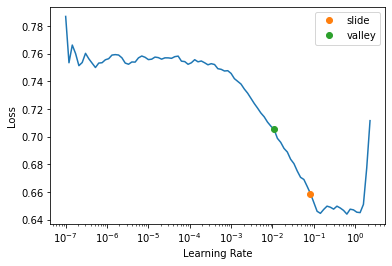

In [249]:
learn.lr_find(suggest_funcs=(slide, valley))

In [251]:
learn.fit(40, lr=0.045)

epoch,train_loss,valid_loss,accuracy,time
0,0.059875,1.133604,0.752014,00:02
1,0.049039,1.033079,0.752589,00:01
2,0.044000,1.133379,0.742232,00:01
3,0.046832,1.034219,0.750288,00:01
4,0.046660,0.968097,0.749137,00:01
5,0.045302,0.944259,0.752589,00:01
6,0.046017,1.184972,0.751438,00:01
7,0.049752,1.089773,0.753165,00:01
8,0.060505,1.000692,0.762371,00:01
9,0.050454,1.066843,0.752014,00:01


In [308]:
tst_df = pd.read_csv('spaceship-titanic/test.csv')
add_features(tst_df)

In [309]:
tst_dl = learn.dls.test_dl(tst_df)

In [310]:
preds,_ = learn.get_preds(dl=tst_dl)

In [312]:
tst_df['Transported'] = (preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId', 'Transported']]
sub_df = sub_df.assign(Transported=sub_df.Transported.map(bool))
sub_df.to_csv('sub.csv', index=False)



In [313]:
! kaggle competitions submit -c spaceship-titanic -f sub.csv -m 'fastai Tabular Pandas framework'

100% 56.8k/56.8k [00:00<00:00, 137kB/s]
Successfully submitted to Spaceship Titanic